# Digit Recognizer using CNN

# Introduction

- MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.
- In this Project, our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

# Dataset Description

- MNIST is a simple computer vision dataset. It consists of 28x28 pixel images of handwritten digits.
- Every MNIST data point, every image, can be thought of as an array of numbers describing how dark each pixel is. Since each image has 28 by 28 pixels, we get a 28x28 array. 
- We can flatten each array into a 28∗28 = 784 dimensional vector. Each component of the vector is a value between zero and one describing the intensity of the pixel. Thus, we generally think of MNIST as being a collection of 784-dimensional vectors.  
- Not all vectors in this 784-dimensional space are MNIST digits. Typical points in this space are very different! To get a sense of what a typical point looks like, we can randomly pick a few points and examine them. In a random point – a random 28x28 image – each pixel is randomly black, white or some shade of gray. The result is that random points look like noise.

# Context

- Images like MNIST digits are very rare. While the MNIST data points are embedded in 784-dimensional space, they live in a very small subspace. 
- One popular theory among machine learning researchers is the manifold hypothesis: MNIST is a low dimensional manifold, sweeping and curving through its high-dimensional embedding space. 
- Another hypothesis, more associated with topological data analysis, is that data like MNIST consists of blobs with tentacle-like protrusions sticking out into the surrounding space.  But no one really knows, so lets explore!

# 1. Importing Dependencies

In [9]:
# Basic Libraries
import numpy as np
import pandas as pd

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPool2D, AveragePooling2D, ZeroPadding2D, Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as k

from tensorflow.keras.datasets import mnist

from keras.utils import np_utils

# Other Files
import pickle
from os import listdir
from os.path import isfile, join
import os
import time

In [10]:
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors = ['b']):
    ax.plot(x, vy, 'b', label = "Validation Loss")
    ax.plot(x, ty, 'r', label = "Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

# 2. Bringing the data to a format acceptable by the CNN

In [11]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if k.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [12]:
# Dumping the data generated into seperate files
with open('x_train.pickle', 'wb') as handle:
    pickle.dump(x_train, handle, protocol = pickle.HIGHEST_PROTOCOL)
with open('y_train.pickle', 'wb') as handle:
    pickle.dump(y_train, handle, protocol = pickle.HIGHEST_PROTOCOL)
with open('x_test.pickle', 'wb') as handle:
    pickle.dump(x_test, handle, protocol = pickle.HIGHEST_PROTOCOL)
with open('y_test.pickle', 'wb') as handle:
    pickle.dump(y_test, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [13]:
# Training and validation files

files = ['x_train.pickle', 'y_train.pickle',
         'x_test.pickle', 'y_test.pickle']

# Load training samples
with open(files[0], 'rb') as img_file:
    x_train = pickle.load(img_file, encoding='bytes')
    
# Load training labels
with open(files[1], 'rb') as lb_file:
    y_train = pickle.load(lb_file, encoding='bytes')
    
# Load validation samples
with open(files[2], 'rb') as img_file_v:
    x_test = pickle.load(img_file_v, encoding='bytes')
    
# Load validation labels
with open(files[3], 'rb') as lb_file_v:
    y_test = pickle.load(lb_file_v, encoding='bytes')

# 3. Data Preprocessing

In [15]:
num_classes = 10

# Transofrm the Features to a float32 type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the input features
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [45]:
print('Shape of Training Data   :', x_train.shape)
print('Shape of Test Data       :', x_test.shape)
print('Shape of Training Lables :', y_train.shape)
print('Shape of Test Lables     :', y_test.shape)

Shape of Training Data   : (60000, 28, 28, 1)
Shape of Test Data       : (10000, 28, 28, 1)
Shape of Training Lables : (60000, 10)
Shape of Test Lables     : (10000, 10)


# 4. Building the model

## 1. Base Model (2 Layer Architecture)

1. Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function as relu
2. Convolutional input layer, 64 feature maps with a size of 3×3, a rectifier activation function as relu
3. Max Pool layer with size 2×2
4. Dropout
5. Flatten layer
6. Fully connected layer with 256 units and a rectifier activation function as relu
7. Fully connected output layer with 10 units and a softmax activation function
8. Compiling the Model with adadelta optimizer and metrices as accuracy

In [16]:
# Initialising the Model_1
Model_1 = Sequential()

# Convolution
Model_1.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = input_shape, activation = 'relu'))
# Convolution
Model_1.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
# Max Pooling
Model_1.add(MaxPool2D(pool_size = (2,2)))
# Dropout
Model_1.add(Dropout(0.25))

# Flattening
Model_1.add(Flatten())

# Full Connection
Model_1.add(Dense(256, activation = 'relu'))
# Dropout
Model_1.add(Dropout(0.25))

# Output Layer
Model_1.add(Dense(num_classes, activation = 'softmax'))

# Compiling Model_1
Model_1.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])

In [17]:
Model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2359552   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [18]:
Model_1_result = Model_1.fit(x_train, y_train, epochs = 15, validation_data = (x_test, y_test), workers = -1, 
                             batch_size = 256)

Epoch 1/15
235/235 [==============================] - 99s 421ms/step - loss: 2.3025 - accuracy: 0.1614 - val_loss: 2.3024 - val_accuracy: 0.1207
Epoch 2/15
235/235 [==============================] - 103s 438ms/step - loss: 2.3024 - accuracy: 0.1332 - val_loss: 2.3024 - val_accuracy: 0.1135
Epoch 3/15
235/235 [==============================] - 104s 443ms/step - loss: 2.3024 - accuracy: 0.1194 - val_loss: 2.3023 - val_accuracy: 0.1135
Epoch 4/15
235/235 [==============================] - 105s 445ms/step - loss: 2.3023 - accuracy: 0.1134 - val_loss: 2.3023 - val_accuracy: 0.1135
Epoch 5/15
235/235 [==============================] - 104s 441ms/step - loss: 2.3023 - accuracy: 0.1129 - val_loss: 2.3023 - val_accuracy: 0.1135
Epoch 6/15
235/235 [==============================] - 102s 433ms/step - loss: 2.3023 - accuracy: 0.1125 - val_loss: 2.3023 - val_accuracy: 0.1135
Epoch 7/15
235/235 [==============================] - 106s 453ms/step - loss: 2.3023 - accuracy: 0.1126 - val_loss: 2.3023 - 

In [19]:
Model_1_evaluation = Model_1.evaluate(x_test, y_test)
print('Test Loss is : {} and the Test Accuracy is: {}'.format(Model_1_evaluation[0], Model_1_evaluation[1]))

313/313 [==============================] - 5s 16ms/step - loss: 2.3021 - accuracy: 0.1135
Test Loss is : 2.3021419048309326 and the Test Accuracy is: 0.11349999904632568


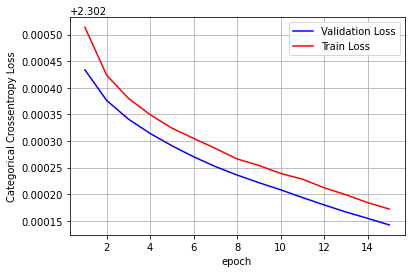

In [20]:
# Plotting Train & Validation Loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1, 16))
vy = Model_1_result.history['val_loss']
ty = Model_1_result.history['loss']

# Calling Function
plt_dynamic(x, vy, ty, ax)

## Model 1 : Conclusions

1. Using our base model we are able to get of only 11.34% training accuracy and 11.35% test accuracy, which is very bad. 

2. So we have options like we should increase the Hidden Layers, add Drop outs, add Batch Normalizations

3. So lets regularize the model. In deep learning drop out is very good form of regularization. Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

4. Drop out literally means we gonna drop some of the neural units randomly from our network, which forces the next layer to learn the patterns again. In this way our model will become more robust and generalizes well.

5. Lets try to add drop out after each CNN layer + MaxPool Layer.

## 2. Model 2 with Drop outs (3 LAYER ARCHITECTURE)

1. Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function as relu
2. Convolutional input layer, 64 feature maps with a size of 3×3, a rectifier activation function as relu
3. Max Pool layer with size 2×2
4. Dropout set to 25%
5. Convolutional input layer, 128 feature maps with a size of 3×3, a rectifier activation function as relu
6. Max Pool layer with size 2×2
7. Dropout set to 50%
8. Flatten layer
9. Fully connected layer with 256 units and a rectifier activation function as relu
10. Dropout set to 50%
11. Fully connected output layer with 10 units and a softmax activation function
12. Compiling the Model with adam optimizer and metrices as accuracy

In [24]:
# Initialising the Model_2
Model_2 = Sequential()

# Convolution
Model_2.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = input_shape, activation = 'relu'))
# Convolution
Model_2.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
# Max Pooling
Model_2.add(MaxPool2D(pool_size = (2,2)))
# Adding Dropouts
Model_2.add(Dropout(0.25))

# Adding 2nd Convolutional Layer
Model_2.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
# Max Pooling
Model_2.add(MaxPool2D(pool_size = (2,2)))
# Adding Dropouts
Model_2.add(Dropout(0.5))

# Flattening
Model_2.add(Flatten())

# Full Connection
Model_2.add(Dense(256, activation = 'relu'))
# Adding Dropouts
Model_2.add(Dropout(0.50))

# Output Layer
Model_2.add(Dense(num_classes, activation = 'softmax'))

# Compiling Model_1
Model_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [25]:
Model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 128)        

In [26]:
Model_2_result = Model_2.fit(x_train, y_train, epochs = 12, validation_data = (x_test, y_test), batch_size = 256, 
                             workers = -1)

Epoch 1/12
235/235 [==============================] - 135s 575ms/step - loss: 1.1053 - accuracy: 0.6180 - val_loss: 0.2364 - val_accuracy: 0.9307
Epoch 2/12
235/235 [==============================] - 134s 572ms/step - loss: 0.2674 - accuracy: 0.9164 - val_loss: 0.1228 - val_accuracy: 0.9608
Epoch 3/12
235/235 [==============================] - 134s 571ms/step - loss: 0.1910 - accuracy: 0.9420 - val_loss: 0.0905 - val_accuracy: 0.9700
Epoch 4/12
235/235 [==============================] - 135s 573ms/step - loss: 0.1623 - accuracy: 0.9503 - val_loss: 0.0803 - val_accuracy: 0.9725
Epoch 5/12
235/235 [==============================] - 139s 592ms/step - loss: 0.1443 - accuracy: 0.9563 - val_loss: 0.0721 - val_accuracy: 0.9754
Epoch 6/12
235/235 [==============================] - 131s 557ms/step - loss: 0.1297 - accuracy: 0.9601 - val_loss: 0.0653 - val_accuracy: 0.9791
Epoch 7/12
235/235 [==============================] - 133s 566ms/step - loss: 0.1191 - accuracy: 0.9643 - val_loss: 0.0582 -

In [27]:
Model_2_evaluation = Model_2.evaluate(x_test, y_test)
print('Test Loss is : {} and the Test Accuracy is: {}'.format(Model_2_evaluation[0], Model_2_evaluation[1]))

313/313 [==============================] - 5s 18ms/step - loss: 0.0425 - accuracy: 0.9859
Test Loss is : 0.04252588376402855 and the Test Accuracy is: 0.9858999848365784


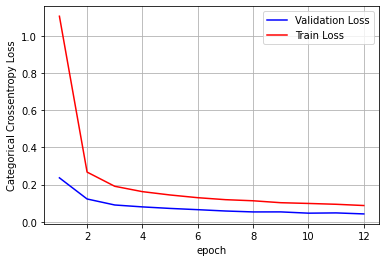

In [30]:
# Plotting Train & Validation Loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1, 13))
vy = Model_2_result.history['val_loss']
ty = Model_2_result.history['loss']

# Calling Function
plt_dynamic(x, vy, ty, ax)

## Model 2: Conclusions 

1. Using our base model we are able to get of only 97.36% training accuracy and 98.58% test accuracy, which is really good than the previous model. 

2. Lets try to improve our model by adding the Hidden Layers, add Drop outs, add Batch Normalizations

## 3. Model 3 with Drop outs, More Layers, Batch Normalization & More Filters (5 Layer Architecture)

1. Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function as relu
2. Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function as relu
3. Max Pool layer with size 2×2
4. Batch Normalization
5. Dropout set to 40%
6. Convolutional input layer, 64 feature maps with a size of 3×3, a rectifier activation function as relu
7. Convolutional input layer, 64 feature maps with a size of 3×3, a rectifier activation function as relu
8. Max Pool layer with size 2×2
9. Batch Normalization
10. Dropout set to 40%
11. Convolutional input layer, 128 feature maps with a size of 3×3, a rectifier activation function as relu
12. Batch Normalization
13. Dropout set to 50%
14. Flatten layer
15. Fully connected layer with 256 units and a rectifier activation function as relu
    Dropout set to 50%
16. Fully connected layer with 128 units and a rectifier activation function as relu
17. Dropout set to 40%
18. Fully connected output layer with 10 units and a softmax activation function
19. Compiling the Model with adam optimizer and metrices as accuracy

In [33]:
# Initialising the Model_3
Model_3 = Sequential()

# Convolution
Model_3.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = input_shape, activation = 'relu'))
# Convolution
Model_3.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
# Max Pooling
Model_3.add(MaxPool2D(pool_size = (2,2)))
# Batch Normalization
Model_3.add(BatchNormalization())
# Adding Dropouts
Model_3.add(Dropout(0.40))

# Convolutional Layer
Model_3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
# Convolutional Layer
Model_3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
# Max Pooling
Model_3.add(MaxPool2D(pool_size = (2,2)))
# Batch Normalization
Model_3.add(BatchNormalization())
# Adding Dropouts
Model_3.add(Dropout(0.40))

# Convolution
Model_3.add(Conv2D(128, kernel_size=3, activation = 'relu'))
# Batch Normalization
Model_3.add(BatchNormalization())
# Adding Dropouts
Model_3.add(Dropout(0.50))

# Flattening
Model_3.add(Flatten())

# Full Connection
Model_3.add(Dense(256, activation = 'relu'))
# Adding Dropouts
Model_3.add(Dropout(0.50))
# Full Connection
Model_3.add(Dense(128, activation = "relu"))
# Adding Dropouts
Model_3.add(Dropout(0.4))

# Output Layer
Model_3.add(Dense(num_classes, activation = 'softmax'))

# Compiling Model_3
Model_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [34]:
Model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_14 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 64)         

In [35]:
Model_3_result = Model_3.fit(x_train, y_train, epochs = 12, validation_data = (x_test, y_test), batch_size = 256,
                             workers = -1)

Epoch 1/12
235/235 [==============================] - 107s 456ms/step - loss: 0.8888 - accuracy: 0.7131 - val_loss: 2.3256 - val_accuracy: 0.0892
Epoch 2/12
235/235 [==============================] - 105s 446ms/step - loss: 0.2480 - accuracy: 0.9269 - val_loss: 2.0792 - val_accuracy: 0.2757
Epoch 3/12
235/235 [==============================] - 103s 438ms/step - loss: 0.1670 - accuracy: 0.9513 - val_loss: 0.6778 - val_accuracy: 0.7839
Epoch 4/12
235/235 [==============================] - 103s 438ms/step - loss: 0.1339 - accuracy: 0.9620 - val_loss: 0.8939 - val_accuracy: 0.7455
Epoch 5/12
235/235 [==============================] - 105s 445ms/step - loss: 0.1211 - accuracy: 0.9657 - val_loss: 64.7175 - val_accuracy: 0.0974
Epoch 6/12
235/235 [==============================] - 101s 431ms/step - loss: 0.1071 - accuracy: 0.9696 - val_loss: 0.3125 - val_accuracy: 0.8939
Epoch 7/12
235/235 [==============================] - 100s 425ms/step - loss: 0.0935 - accuracy: 0.9728 - val_loss: 0.6180 

In [36]:
Model_3_evaluation = Model_3.evaluate(x_test, y_test)
print('Test Loss is : {} and the Test Accuracy is: {}'.format(Model_3_evaluation[0], Model_3_evaluation[1]))

313/313 [==============================] - 4s 12ms/step - loss: 6.1978 - accuracy: 0.3836
Test Loss is : 6.197793960571289 and the Test Accuracy is: 0.38359999656677246


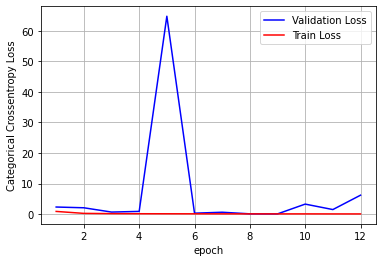

In [38]:
# Plotting Train & Validation Loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1, 13))
vy = Model_3_result.history['val_loss']
ty = Model_3_result.history['loss']

# Calling Function
plt_dynamic(x, vy, ty, ax)

## Model 3. Conclusions: 

- The Model is overfitting as the Train & Test accuracy has great difference. Lets reduce number of epochs to 10.
- Lets try to improve our model by adding the Hidden Layers, add Drop outs, Batch Normalizations, padding and weight initializations

# Model 4: with Increased Dropouts, More Layers, More Filters, Padding, Using He Kernel Initializer and using Batch Normalization (7 Layer Architecture)

1. Convolutional input layer, 16 feature maps with a size of 3×3, a rectifier activation function as relu, initialization as He, padding same
2. Convolutional input layer, 16 feature maps with a size of 3×3, a rectifier activation function as relu, initialization as He, padding same
3. Max Pool layer with size 2×2
4. Batch Normalization
5. Dropout set to 25%
6. Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function as relu, initialization as He, padding same
7. Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function as relu
8. Max Pool layer with size 2×2
9. Batch Normalization
10. Dropout set to 30%
11. Convolutional input layer, 64 feature maps with a size of 3×3, a rectifier activation function as relu, initialization as He, padding same
12. Convolutional input layer, 64 feature maps with a size of 3×3, a rectifier activation function as relu, initialization as He, padding same
13. Max Pool layer with size 2×2
14. Batch Normalization
15. Dropout set to 30%
16. Convolutional input layer, 128 feature maps with a size of 3×3, a rectifier activation function as relu, initialization as He, padding same
17. Max Pool layer with size 2×2
18. Batch Normalization
19. Dropout set to 50%
20. Flatten layer
21. Fully connected layer with 256 units and a rectifier activation function as relu
    Dropout set to 50%
22. Fully connected layer with 128 units and a rectifier activation function as relu
23. Dropout set to 40%
24. Fully connected output layer with 10 units and a softmax activation function
25. Compiling the Model with adam optimizer and metrices as accuracy

In [42]:
# Initialising the Model_4
Model_4 = Sequential()

# Convolution
Model_4.add(Conv2D(filters = 16, kernel_size = (3,3), input_shape = input_shape, activation = 'relu', padding = 'same',
                   kernel_initializer = 'he_uniform'))
# Convolution
Model_4.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', kernel_initializer = 'he_uniform', 
                   padding='same'))
# Max Pooling
Model_4.add(MaxPool2D(pool_size = (2,2)))
# Batch Normalization
Model_4.add(BatchNormalization())
# Adding Dropouts
Model_4.add(Dropout(0.25))


# Convolution
Model_4.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', kernel_initializer='he_uniform', 
                   padding='same'))
# Convolution
Model_4.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', kernel_initializer='he_uniform', 
                   padding='same'))
# Max Pooling
Model_4.add(MaxPool2D(pool_size = (2,2)))
# Batch Normalization
Model_4.add(BatchNormalization())
# Adding Dropouts
Model_4.add(Dropout(0.30))


# Convolution
Model_4.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', kernel_initializer='he_uniform', 
                   padding='same'))
# Convolution
Model_4.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', kernel_initializer='he_uniform', 
                   padding='same'))
# Max Pooling
Model_4.add(MaxPool2D(pool_size = (2,2)))
# Batch Normalization
Model_4.add(BatchNormalization())
# Adding Dropouts
Model_4.add(Dropout(0.40))


# Convolution
Model_4.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', kernel_initializer='he_uniform', 
                   padding='same'))
# Max Pooling
Model_4.add(MaxPool2D(pool_size = (2,2)))
# Batch Normalization
Model_4.add(BatchNormalization())
# Adding Dropouts
Model_4.add(Dropout(0.50))

# Flattening
Model_4.add(Flatten())

# Full Connection
Model_4.add(Dense(256, activation = 'relu', kernel_initializer='he_uniform'))
# Adding Dropouts
Model_4.add(Dropout(0.50))
# Full Connection
Model_4.add(Dense(128, activation = "relu"))


# Output Layer
Model_4.add(Dense(num_classes, activation = 'softmax'))

# Compiling Model_4
Model_4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [43]:
Model_4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
dropout_30 (Dropout)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 14, 14, 32)       

In [44]:
Model_4_result = Model_4.fit(x_train, y_train, epochs = 10, validation_data = (x_test, y_test), batch_size = 256,
                             workers = -1)

Epoch 1/10
235/235 [==============================] - 103s 439ms/step - loss: 1.0970 - accuracy: 0.6382 - val_loss: 4.1881 - val_accuracy: 0.1010
Epoch 2/10
235/235 [==============================] - 102s 436ms/step - loss: 0.2657 - accuracy: 0.9190 - val_loss: 2.1321 - val_accuracy: 0.3537
Epoch 3/10
235/235 [==============================] - 107s 457ms/step - loss: 0.1733 - accuracy: 0.9485 - val_loss: 0.3010 - val_accuracy: 0.9113
Epoch 4/10
235/235 [==============================] - 104s 441ms/step - loss: 0.1382 - accuracy: 0.9592 - val_loss: 0.1915 - val_accuracy: 0.9404
Epoch 5/10
235/235 [==============================] - 100s 427ms/step - loss: 0.1166 - accuracy: 0.9657 - val_loss: 0.0732 - val_accuracy: 0.9780
Epoch 6/10
235/235 [==============================] - 100s 426ms/step - loss: 0.1007 - accuracy: 0.9710 - val_loss: 0.0513 - val_accuracy: 0.9836
Epoch 7/10
235/235 [==============================] - 101s 428ms/step - loss: 0.0886 - accuracy: 0.9739 - val_loss: 0.0494 -

In [46]:
Model_4_evaluation = Model_4.evaluate(x_test, y_test)
print('Test Loss is : {} and the Test Accuracy is: {}'.format(Model_4_evaluation[0], Model_4_evaluation[1]))

313/313 [==============================] - 4s 12ms/step - loss: 0.0514 - accuracy: 0.9844
Test Loss is : 0.051353905349969864 and the Test Accuracy is: 0.9843999743461609


In [ ]:
# Plotting Train & Validation Loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1, 11))
vy = Model_4_result.history['val_loss']
ty = Model_4_result.history['loss']

# Calling Function
plt_dynamic(x, vy, ty, ax)

In [47]:
from prettytable import PrettyTable

pretty = PrettyTable()

pretty.field_names = ['Sr.No','MODEL','train_accuracy','test_accuracy','train_loss','test_loss']

pretty.add_row(['1','2-LAYER WITH KERNEL SIZE ','0.1124','0.1134','2.3022','2.3021'])
pretty.add_row(['2','3-LAYER WITH KERNEL SIZE ','0.9736','0.9859','0.0877','0.0425'])
pretty.add_row(['3','5-LAYER WITH KERNEL SIZE ','0.9799','0.3836','0.0717','6.1720'])
pretty.add_row(['4','7-LAYER WITH KERNEL SIZE ','0.9797','0.9844','0.0697','0.0514'])


print(pretty)

+-------+---------------------------+----------------+---------------+------------+-----------+
| Sr.No |           MODEL           | train_accuracy | test_accuracy | train_loss | test_loss |
+-------+---------------------------+----------------+---------------+------------+-----------+
|   1   | 2-LAYER WITH KERNEL SIZE  |     0.1124     |     0.1134    |   2.3022   |   2.3021  |
|   2   | 3-LAYER WITH KERNEL SIZE  |     0.9736     |     0.9859    |   0.0877   |   0.0425  |
|   3   | 5-LAYER WITH KERNEL SIZE  |     0.9799     |     0.3836    |   0.0717   |   6.1720  |
|   4   | 7-LAYER WITH KERNEL SIZE  |     0.9797     |     0.9844    |   0.0697   |   0.0514  |
+-------+---------------------------+----------------+---------------+------------+-----------+


# End Results

- It can be observed from the above table that the accuracy we obatined is really good. We Get maximum test accuracy of about 98.44 by using increased Dropouts, more Layers, more Filters, Padding, using He Kernel Initializer and using Batch Normalization.
- So we are able to classify digits accurately for most of the cases.

# End of File